In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = 'p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170M/170M [00:18<00:00, 9.03MB/s]


Extracting p1ch7/cifar-10-python.tar.gz to p1ch7/


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
            nn.Linear(
                3072,  # <1>
                512,   # <2>
            ),
            nn.Tanh(),
            nn.Linear(
                512,   # <2>
                n_out, # <3>
            )
        )

In [7]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [11]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

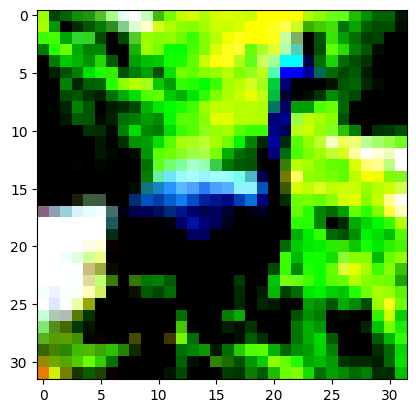

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)

In [14]:
out = model(img_batch)
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward0>)

In [15]:
_, index = torch.max(out, dim=1)

index

tensor([1])

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out)

tensor([0.3024])

In [20]:
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [21]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison

tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [22]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [23]:
nll_comparison = torch.tensor([neg_log_likelihood(o)
                               for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [24]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [25]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

softmax(x)

tensor([[0., 1.]])

In [27]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [28]:
log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [30]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

In [31]:
loss = nn.NLLLoss()

In [32]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5077, grad_fn=<NllLossBackward0>)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 4.970345
Epoch: 1, Loss: 1.496101
Epoch: 2, Loss: 5.965734
Epoch: 3, Loss: 5.456360
Epoch: 4, Loss: 8.263103
Epoch: 5, Loss: 7.556247
Epoch: 6, Loss: 12.164555
Epoch: 7, Loss: 6.562623
Epoch: 8, Loss: 10.487607
Epoch: 9, Loss: 3.622941
Epoch: 10, Loss: 7.431984
Epoch: 11, Loss: 8.384097
Epoch: 12, Loss: 9.000412
Epoch: 13, Loss: 10.115946
Epoch: 14, Loss: 17.631962
Epoch: 15, Loss: 7.163721
Epoch: 16, Loss: 13.356232
Epoch: 17, Loss: 19.606689
Epoch: 18, Loss: 16.856281
Epoch: 19, Loss: 17.045574
Epoch: 20, Loss: 8.984884
Epoch: 21, Loss: 0.086462
Epoch: 22, Loss: 7.062708
Epoch: 23, Loss: 12.056187
Epoch: 24, Loss: 0.521504
Epoch: 25, Loss: 0.167765
Epoch: 26, Loss: 3.343651
Epoch: 27, Loss: 8.203370
Epoch: 28, Loss: 13.065648
Epoch: 29, Loss: 15.000914
Epoch: 30, Loss: 10.890163
Epoch: 31, Loss: 7.686925
Epoch: 32, Loss: 4.593851
Epoch: 33, Loss: 11.981665
Epoch: 34, Loss: 10.078283
Epoch: 35, Loss: 15.812454


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.604063
Epoch: 1, Loss: 0.597974
Epoch: 2, Loss: 0.271415
Epoch: 3, Loss: 0.451056
Epoch: 4, Loss: 0.629758
Epoch: 5, Loss: 0.458762
Epoch: 6, Loss: 0.277813
Epoch: 7, Loss: 0.406921
Epoch: 8, Loss: 0.951961
Epoch: 9, Loss: 0.433738
Epoch: 10, Loss: 0.351960
Epoch: 11, Loss: 0.355687
Epoch: 12, Loss: 0.518611
Epoch: 13, Loss: 0.262623
Epoch: 14, Loss: 0.221969
Epoch: 15, Loss: 0.774132
Epoch: 16, Loss: 0.324406
Epoch: 17, Loss: 0.447701
Epoch: 18, Loss: 0.299780
Epoch: 19, Loss: 0.267090
Epoch: 20, Loss: 0.279828
Epoch: 21, Loss: 0.197123
Epoch: 22, Loss: 0.196783
Epoch: 23, Loss: 0.328715
Epoch: 24, Loss: 0.334952
Epoch: 25, Loss: 0.500689
Epoch: 26, Loss: 0.186956
Epoch: 27, Loss: 0.138649
Epoch: 28, Loss: 0.239988
Epoch: 29, Loss: 0.495020
Epoch: 30, Loss: 0.251347
Epoch: 31, Loss: 0.088298
Epoch: 32, Loss: 0.175127
Epoch: 33, Loss: 0.208338
Epoch: 34, Loss: 0.145656
Epoch: 35, Loss: 0.129570
Epoch: 36, Loss: 0.200110
Epoch: 37, Loss: 0.133076
Epoch: 38, Loss: 0.230

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.732168
Epoch: 1, Loss: 0.348352
Epoch: 2, Loss: 0.318960
Epoch: 3, Loss: 0.313264
Epoch: 4, Loss: 0.378358
Epoch: 5, Loss: 0.276529
Epoch: 6, Loss: 0.443889
Epoch: 7, Loss: 0.436946
Epoch: 8, Loss: 0.324288
Epoch: 9, Loss: 0.274647
Epoch: 10, Loss: 0.291681
Epoch: 11, Loss: 0.242894
Epoch: 12, Loss: 0.301849
Epoch: 13, Loss: 0.202063
Epoch: 14, Loss: 0.389276
Epoch: 15, Loss: 0.167129
Epoch: 16, Loss: 0.135282
Epoch: 17, Loss: 0.385485
Epoch: 18, Loss: 0.453852
Epoch: 19, Loss: 0.641304
Epoch: 20, Loss: 0.287667
Epoch: 21, Loss: 0.337029
Epoch: 22, Loss: 0.393282
Epoch: 23, Loss: 0.409480
Epoch: 24, Loss: 0.138473
Epoch: 25, Loss: 0.690729
Epoch: 26, Loss: 0.572156
Epoch: 27, Loss: 0.078534
Epoch: 28, Loss: 0.324833
Epoch: 29, Loss: 0.262829
Epoch: 30, Loss: 0.430449
Epoch: 31, Loss: 0.071872
Epoch: 32, Loss: 0.058039
Epoch: 33, Loss: 0.052903
Epoch: 34, Loss: 0.065879
Epoch: 35, Loss: 0.107696
Epoch: 36, Loss: 0.305224
Epoch: 37, Loss: 0.098637
Epoch: 38, Loss: 0.139

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.997700


In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.821000


In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.641261
Epoch: 1, Loss: 0.525149
Epoch: 2, Loss: 0.466143
Epoch: 3, Loss: 0.451913
Epoch: 4, Loss: 0.343860
Epoch: 5, Loss: 0.309738
Epoch: 6, Loss: 0.485261
Epoch: 7, Loss: 0.283789
Epoch: 8, Loss: 0.301561
Epoch: 9, Loss: 0.408200
Epoch: 10, Loss: 0.346715
Epoch: 11, Loss: 0.358134
Epoch: 12, Loss: 0.388485
Epoch: 13, Loss: 0.378096
Epoch: 14, Loss: 0.518019
Epoch: 15, Loss: 0.359279
Epoch: 16, Loss: 0.420371
Epoch: 17, Loss: 0.366249
Epoch: 18, Loss: 0.282639
Epoch: 19, Loss: 0.468854
Epoch: 20, Loss: 0.467920
Epoch: 21, Loss: 0.237441
Epoch: 22, Loss: 0.243472
Epoch: 23, Loss: 0.566929
Epoch: 24, Loss: 0.316143
Epoch: 25, Loss: 0.336322
Epoch: 26, Loss: 0.473064
Epoch: 27, Loss: 0.407040
Epoch: 28, Loss: 0.252989
Epoch: 29, Loss: 0.195740
Epoch: 30, Loss: 0.663084
Epoch: 31, Loss: 0.659899
Epoch: 32, Loss: 0.285113
Epoch: 33, Loss: 0.212042
Epoch: 34, Loss: 0.324017
Epoch: 35, Loss: 0.097063
Epoch: 36, Loss: 0.181754
Epoch: 37, Loss: 0.091362
Epoch: 38, Loss: 0.069

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.999700


In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

Accuracy: 0.801000


In [ ]:
sum([p.numel() for p in model.parameters()])

3737474

In [ ]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

3737474

In [ ]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

sum([p.numel() for p in first_model.parameters()])

1574402

In [ ]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [ ]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [ ]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3)

In [ ]:
conv.weight.shape

torch.Size([16, 3, 3, 3])

In [ ]:
conv.bias.shape

torch.Size([16])

In [ ]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))

In [ ]:
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


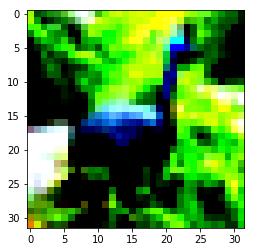

In [ ]:
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.show()

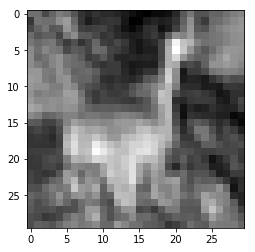

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
output.shape

torch.Size([1, 16, 30, 30])

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [ ]:
output = conv(img.unsqueeze(0))

output.shape

torch.Size([1, 1, 32, 32])

In [ ]:
with torch.no_grad():
    conv.bias.zero_()

In [ ]:
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

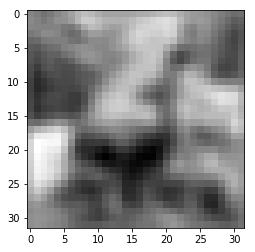

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

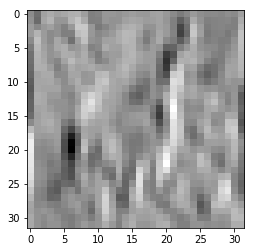

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [ ]:
pool = nn.MaxPool2d(2)

In [ ]:
output = pool(img.unsqueeze(0))

output.shape

torch.Size([1, 3, 16, 16])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            ...)

TypeError: ellipsis is not a Module subclass

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # WARNING: something missing here
            nn.Linear(512, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [ ]:
sum([p.numel() for p in model.parameters()])

In [ ]:
model(img.unsqueeze(0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act4(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()

sum([p.numel() for p in model.parameters()])

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print("Accuracy: %f" % (correct / total))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

model = Net()
sum([p.numel() for p in model.parameters()])

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8*8*8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

model(img.unsqueeze(0))